# Robustness Experiments

We use the models from Chen2020 work and see roughly how the perform agains simple attacks.

In [1]:
# imports
import os
import sys
# add to the path the source files
sys.path.append(os.path.dirname(os.getcwd()))
cwd = os.path.dirname(os.getcwd())

import networkx as nx
import dgl
import torch
from networkx.generators import random_regular_graph, gnp_random_graph
from torch.utils.data import DataLoader
import tqdm
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from src.dataset.counting_algorithm import subgraph_counting, subgraph_counting_all
from src.dataset.graph_permutation import GraphPermutation
from src.lrp.dataset_synthetic import DglSyntheticDataset, collate_lrp_dgl_light
from src.lrp.model_synthetic import LRP_synthetic


In [2]:
def np_sparse_to_pt_sparse(matrix):
    coo = matrix.tocoo()
    values = coo.data
    indices = np.vstack((coo.row, coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = coo.shape

    return torch.sparse.FloatTensor(i, v, torch.Size(shape))

def build_perm_pooling_sp_matrix(split_list, pooling = "sum"):
    dim0, dim1 = len(split_list), sum(split_list)
    col = np.arange(dim1)
    row = np.array([i for i, count in enumerate(split_list) for j in range(count)])
    data = np.ones((dim1, ))
    pooling_sp_matrix = csr_matrix((data, (row, col)), shape = (dim0, dim1))

    if pooling == "mean":
        pooling_sp_matrix = normalize(pooling_sp_matrix, norm='l1', axis=1)
    
    return np_sparse_to_pt_sparse(pooling_sp_matrix)

# Progressive edge creation

Test how the model performs against progressively adding and edge from the graph. 

We firstly analyze the task of conting triangles, which should be the easiest. 

In [3]:
# generate the data

graph_permutation = GraphPermutation()
dataset_path = os.path.join(cwd, "data")
dataset_name = "triangles_progressive_deletion"
seed = 1
n = 10
d = 5
p = 0.3
n_del = 10

#seed_graph = random_regular_graph(n=n, d=d, seed=seed)
seed_graph = gnp_random_graph(n=n, p=p, seed=seed, directed=False)
print(f'Number of edges: {seed_graph.number_of_edges()}' )
#graphs = [graph_permutation.edge_deletion(seed_graph, seed=seed)]
graphs = [seed_graph]
# add the remaining graphs
for i in range(n_del): #bug in the database code
    graphs.append(graph_permutation.edge_creation(graphs[-1], num=2, seed=i))
counts = []
for graph in graphs:
    counts.append(subgraph_counting(graph, 'g31'))
counts = {"triangle": torch.tensor(counts)}
# save the graphs in dgl format
dgl_graphs = []
for graph in graphs:
    dgl_graphs.append(dgl.from_networkx(graph))
# save the graphs
dgl.save_graphs(os.path.join(dataset_path, dataset_name + ".bin"), dgl_graphs, counts)



Number of edges: 18


cuda:0
Label variance:  391.68595041322305
Trying to load LRP!
LRP file exists!
LRP file format correct!  16


/home/francesco/miniconda3/envs/thesis/lib/python3.10/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/francesco/miniconda3/envs/thesis/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


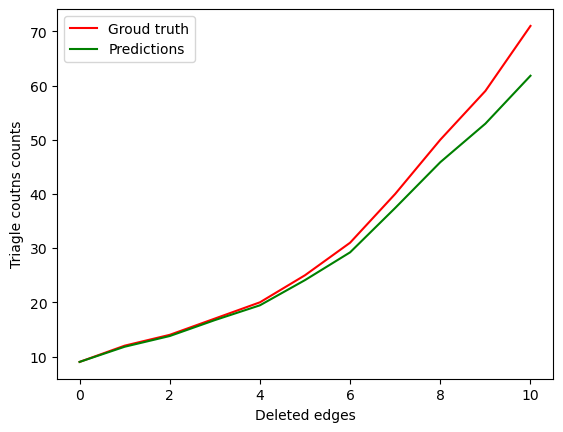

In [4]:
# compute the counts with the models
#model_path = os.path.join(cwd, "models/lrp/lrp0triangle_data1_1668436817.pkl")
model_path = os.path.join(cwd, "models/lrp/lrp0triangle_data2_1668436818.pkl")

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)
dataset = DglSyntheticDataset(dataset_name = dataset_name, dataset_path = dataset_path,task = "triangle", full_permutation = False)
loader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_lrp_dgl_light)
hyperparam_list = {
        'lrp_length': 16,
        'num_tasks': 1,
        'lrp_in_dim': 1,
        'hid_dim': 128,
        'num_layers': 1,
        'bn': False,
        'lr': 0.001,
        'mlp': False
}
model = LRP_synthetic(
    num_tasks = hyperparam_list['num_tasks'],
    lrp_length = hyperparam_list['lrp_length'],
    lrp_in_dim = hyperparam_list['lrp_in_dim'],
    hid_dim = hyperparam_list['hid_dim'],
    num_layers = hyperparam_list['num_layers'],
    bn = hyperparam_list['bn'],
    mlp = hyperparam_list['mlp']
).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()
predictions = []
with torch.no_grad():
    for (batch, split_list, sp_matrices, label) in loader:
        batch = batch.to(device)
        batch.ndata['feat'] = torch.ones(batch.number_of_nodes(), 1).to(device)
        batch.edata['feat'] = torch.ones(batch.number_of_edges(), 1).to(device)
        mean_pooling_matrix = build_perm_pooling_sp_matrix(split_list, "mean").to(device)

        n_to_perm_length_sp_matrix = np_sparse_to_pt_sparse(sp_matrices[0]).to(device)
        e_to_perm_length_sp_matrix = np_sparse_to_pt_sparse(sp_matrices[1]).to(device)

        degs = batch.in_degrees(list(range(batch.number_of_nodes()))).type(torch.FloatTensor).to(device)

        pred = model(batch, mean_pooling_matrix, degs, n_to_perm_length_sp_matrix, e_to_perm_length_sp_matrix).cpu()
        predictions.append(pred)

# plot the predictions vs the grount truth
x = list(range(len(graphs)))
plt.plot(x, counts["triangle"], color = 'r', label = 'Groud truth')
plt.plot(x, predictions, color = 'g', label = 'Predictions')
plt.legend()
plt.xlabel('Deleted edges')
plt.ylabel('Triagle coutns counts')
plt.show()




# Single permutation

Apply a single permutation to set of synthetic graphs and see the difference in the mse betwee teh original graphs and the permuted ones

In [5]:
# generate graphs
graph_permutation = GraphPermutation()
dataset_path = os.path.join(cwd, "data")
dataset_name = "triangles_edgle_deletion"

m = 10
n = 15
d = 3
p = 0.3

graphs = []
counts = []
dgl_graphs = []
for i in range(m):
    graphs.append(gnp_random_graph(n=n, p=p, seed=i, directed=False))
    #graphs.append(random_regular_graph(n=n, d=d, seed=i))
    counts.append(subgraph_counting(graphs[-1], 'g31'))
    dgl_graphs.append(dgl.from_networkx(graphs[-1]))

# perturbation
pert_graphs = []
pert_counts = []
pert_dgl_graphs = []
for i, graph in enumerate(graphs):
    pert_graphs.append(graph_permutation.edge_deletion(graph, seed=i))
    pert_counts.append(subgraph_counting(pert_graphs[-1], 'g31'))
    dgl_graphs.append(dgl.from_networkx(pert_graphs[-1]))
ground_truths = {'triangle': torch.tensor(counts + pert_counts)}
dgl.save_graphs(os.path.join(dataset_path, dataset_name + ".bin"), dgl_graphs + pert_dgl_graphs, ground_truths)



In [6]:
# compute the counts with the models
model_path = os.path.join(cwd, "models/lrp/lrp0triangle_data1_1668436817.pkl")
#model_path = os.path.join(cwd, "models/lrp/lrp0triangle_data2_1668436818.pkl")
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
dataset = DglSyntheticDataset(dataset_name = dataset_name, dataset_path = dataset_path,task = "triangle", full_permutation = False)
loader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_lrp_dgl_light)
hyperparam_list = {
        'lrp_length': 16,
        'num_tasks': 1,
        'lrp_in_dim': 1,
        'hid_dim': 128,
        'num_layers': 1,
        'bn': False,
        'lr': 0.001,
        'mlp': False
}
model = LRP_synthetic(
    num_tasks = hyperparam_list['num_tasks'],
    lrp_length = hyperparam_list['lrp_length'],
    lrp_in_dim = hyperparam_list['lrp_in_dim'],
    hid_dim = hyperparam_list['hid_dim'],
    num_layers = hyperparam_list['num_layers'],
    bn = hyperparam_list['bn'],
    mlp = hyperparam_list['mlp']
).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()
predictions = []
with torch.no_grad():
    for (batch, split_list, sp_matrices, label) in loader:
        batch = batch.to(device)
        batch.ndata['feat'] = torch.ones(batch.number_of_nodes(), 1).to(device)
        batch.edata['feat'] = torch.ones(batch.number_of_edges(), 1).to(device)
        mean_pooling_matrix = build_perm_pooling_sp_matrix(split_list, "mean").to(device)

        n_to_perm_length_sp_matrix = np_sparse_to_pt_sparse(sp_matrices[0]).to(device)
        e_to_perm_length_sp_matrix = np_sparse_to_pt_sparse(sp_matrices[1]).to(device)

        degs = batch.in_degrees(list(range(batch.number_of_nodes()))).type(torch.FloatTensor).to(device)

        pred = model(batch, mean_pooling_matrix, degs, n_to_perm_length_sp_matrix, e_to_perm_length_sp_matrix).cpu()
        predictions.append(pred)

pred_original = torch.tensor(predictions[:m]).cpu()
pred_pert = torch.tensor(predictions[m:]).cpu()
loss = torch.nn.MSELoss()
mse_orig = loss(dataset.labels[:m].cpu(), pred_original)
mse_pert = loss(dataset.labels[m:].cpu(), pred_pert)

print(f'MSE on the original dataset: {mse_orig}')
print(f'Mse on the perturbed graphs: {mse_pert}')

Label variance:  56.36
Trying to load LRP!
LRP file does not exist!
Preprocessing LRP!


100%|██████████| 20/20 [00:05<00:00,  3.57it/s]


LRP generated with correct format
Saving LRP!
Saving LRP FINISHED!
MSE on the original dataset: 0.1118617057800293
Mse on the perturbed graphs: 0.09615151584148407


# Progressive edge creation

Create prograssively a specific number of edges on a set of graphs and look how the model keeps up with the predictions accuracy when the graphs are out of distribution. To have statistically significan results do the same procedure on a set of graphs.

We compute two different metrics to detect the accuracy of the predictions:
- mean absolute difference
- mean absolute difference divided by the true count, to detect if the variance in error is give only by the fact that the counts are increasing or we have also an increased error proportionally

Moreover, we plot also the area of teh standard deviation of the errors across all the graphs.

In [7]:
graph_permutation = GraphPermutation()
dataset_path = os.path.join(cwd, "data")
dataset_name = "triangles_progressive_deletion_average"
seed = 1 # for reproducibility
m = 100
n = 10
p = 0.3
n_del = 10
motif_type = 'g31'
motif_name = 'triangle'

counts = []
graphs = []
dgl_graphs = []
for i in range(m):
    seed_graph = gnp_random_graph(n=n, p=p, seed=seed*i, directed=False)
    graphs.append(seed_graph)
    dgl_graphs.append(dgl.from_networkx(seed_graph))
    for j in range(n_del):
        graphs.append(graph_permutation.edge_creation(graph=graphs[-1], num = 2, seed=seed*i*j))
        dgl_graphs.append(dgl.from_networkx(graphs[-1]))
for graph in graphs:
    counts.append(subgraph_counting(graph, motif_type))
ground_truths = {motif_name: torch.tensor(counts)}
dgl.save_graphs(os.path.join(dataset_path, dataset_name + ".bin"), dgl_graphs, ground_truths)


Label variance:  295.5265090909091
Trying to load LRP!
LRP file exists!
LRP file format correct!  16


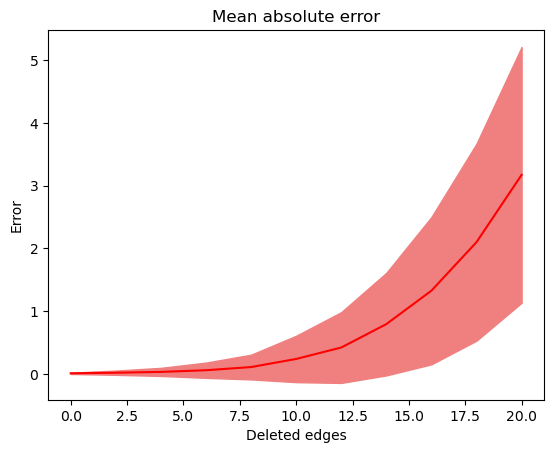

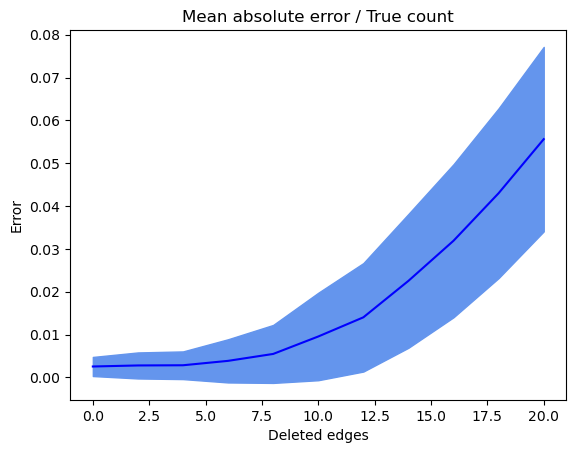

In [8]:
# compute the counts with the models
model_path = os.path.join(cwd, "models/lrp/lrp0triangle_data1_1668436817.pkl")
#model_path = os.path.join(cwd, "models/lrp/lrp0triangle_data2_1668436818.pkl")
#model_path = os.path.join(cwd, "models/lrp/lrp0chordal_cycle_data1_1668436821.pkl")

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
dataset = DglSyntheticDataset(dataset_name = dataset_name, dataset_path = dataset_path,task = motif_name, full_permutation = False)
loader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_lrp_dgl_light)
hyperparam_list = {
        'lrp_length': 16,
        'num_tasks': 1,
        'lrp_in_dim': 1,
        'hid_dim': 128,
        'num_layers': 1,
        'bn': False,
        'lr': 0.001,
        'mlp': False
}
model = LRP_synthetic(
    num_tasks = hyperparam_list['num_tasks'],
    lrp_length = hyperparam_list['lrp_length'],
    lrp_in_dim = hyperparam_list['lrp_in_dim'],
    hid_dim = hyperparam_list['hid_dim'],
    num_layers = hyperparam_list['num_layers'],
    bn = hyperparam_list['bn'],
    mlp = hyperparam_list['mlp']
).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()
predictions = []
with torch.no_grad():
    for (batch, split_list, sp_matrices, label) in loader:
        batch = batch.to(device)
        batch.ndata['feat'] = torch.ones(batch.number_of_nodes(), 1).to(device)
        batch.edata['feat'] = torch.ones(batch.number_of_edges(), 1).to(device)
        mean_pooling_matrix = build_perm_pooling_sp_matrix(split_list, "mean").to(device)

        n_to_perm_length_sp_matrix = np_sparse_to_pt_sparse(sp_matrices[0]).to(device)
        e_to_perm_length_sp_matrix = np_sparse_to_pt_sparse(sp_matrices[1]).to(device)

        degs = batch.in_degrees(list(range(batch.number_of_nodes()))).type(torch.FloatTensor).to(device)

        pred = model(batch, mean_pooling_matrix, degs, n_to_perm_length_sp_matrix, e_to_perm_length_sp_matrix).item()
        predictions.append(pred)

#avrege the errors
counts = np.array(counts).reshape((m,n_del+1))
#counts_no_zeros = 
predictions = np.array(predictions).reshape((m,n_del+1))

abs_error = np.abs(counts - predictions)
abs_error_perc = np.abs(counts - predictions)/(counts+1)
mean_abs_error = np.mean(abs_error, axis = 0)
std_abs_error = np.std(abs_error, axis = 0)
mean_abs_error_perc  = np.mean(abs_error_perc , axis = 0)
std_abs_error_perc = np.std(abs_error_perc , axis = 0)

# plot the predictions vs the grount truth
x = list(range(0, 2*(n_del+1),2))
plt.plot(x, mean_abs_error, color = 'r')
plt.fill_between(x, mean_abs_error+std_abs_error, mean_abs_error-std_abs_error, color = 'lightcoral')
plt.xlabel('Deleted edges')
plt.ylabel('Error')
plt.title('Mean absolute error')
plt.show()
plt.plot(x, mean_abs_error_perc, color = 'b')
plt.fill_between(x, mean_abs_error_perc+std_abs_error_perc, mean_abs_error_perc-std_abs_error_perc, color = 'cornflowerblue')
plt.xlabel('Deleted edges')
plt.ylabel('Error')
plt.title('Mean absolute error / True count')
plt.show()